## CHAPTER 11 - Training Deep Neural Networks

In [1]:
import sys
import os

from datetime import datetime, timedelta

import pandas as pd
import numpy as np

import re
import matplotlib.pyplot as plt

pd.options.display.max_rows=500
pd.options.display.max_columns=500

### 11.1 - Glorot, He, LeCun Activation Function

In [2]:
import tensorflow as tf
from tensorflow import keras

In [3]:
keras.layers.Dense(10, activation = "relu", kernel_initializer = "he_normal")

In [4]:
he_avg_init = keras.initializers.VarianceScaling(scale=2., mode = "fan_avg", distribution = 'uniform')

keras.layers.Dense(10, activation = "sigmoid", kernel_initializer=he_avg_init)

In [5]:
model = keras.models.Sequential([
    keras.layers.Dense(10, kernel_initializer = "he_normal"),
    keras.layers.LeakyReLU(alpha=0.2),
    keras.layers.Dense(10)
])

### 11.2 - Batch Normalization 

In [6]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

#### 2 Trainable vars and 2 non-trainable

In [7]:
[(var.name, var.trainable) for var in model.layers[1].variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [8]:
model.layers[1].updates

C:\Users\d12669\AppData\Roaming\Python\Python37\site-packages\keras\engine\base_layer.py:1348: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


[]

### 11.3 Gradient Clipping

In [9]:
optimizer = keras.optimizers.SGD(clipvalue = 1.0)
model.compile(loss='mse', optimizer=optimizer)

### 11.4 Transfering Learning w/ Keras

Reusing a Keras model
Let's split the fashion MNIST training set in two:

X_train_A: all images of all items except for sandals and shirts (classes 5 and 6).
X_train_B: a much smaller training set of just the first 200 images of sandals or shirts.
The validation set and the test set are also split this way, but without restricting the number of images.

We will train a model on set A (classification task with 8 classes), and try to reuse it to tackle set B (binary classification). We hope to transfer a little bit of knowledge from task A to task B, since classes in set A (sneakers, ankle boots, coats, t-shirts, etc.) are somewhat similar to classes in set B (sandals and shirts). However, since we are using Dense layers, only patterns that occur at the same location can be reused (in contrast, convolutional layers will transfer much better, since learned patterns can be detected anywhere on the image, as we will see in the CNN chapter).

In [10]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [11]:
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [12]:
X_train_A.shape

(43986, 28, 28)

In [13]:
X_train_B.shape

(200, 28, 28)

In [14]:
tf.random.set_seed(42)
np.random.seed(42)

In [15]:
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

In [16]:
model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                metrics=["accuracy"])

In [17]:
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                    validation_data=(X_valid_A, y_valid_A))

Epoch 1/20
1375/1375 [==============================] - 6s 3ms/step - loss: 0.5926 - accuracy: 0.8103 - val_loss: 0.3890 - val_accuracy: 0.8677
Epoch 2/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.3523 - accuracy: 0.8786 - val_loss: 0.3290 - val_accuracy: 0.8822
Epoch 3/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.3170 - accuracy: 0.8895 - val_loss: 0.3014 - val_accuracy: 0.8989
Epoch 4/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.2972 - accuracy: 0.8974 - val_loss: 0.2892 - val_accuracy: 0.9016
Epoch 5/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.2834 - accuracy: 0.9023 - val_loss: 0.2774 - val_accuracy: 0.9071
Epoch 6/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.2729 - accuracy: 0.9063 - val_loss: 0.2733 - val_accuracy: 0.9071
Epoch 7/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.2640 - accuracy: 0.9091 - val_loss: 0.2719 - val_accuracy:

In [18]:
model_A.save("my_model_A.h5")

In [19]:
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

In [20]:
model_B_on_A = keras.models.Sequential(model_A_clone.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

In [21]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False
    
model_B_on_A.compile(loss="binary_crossentropy", optimizer="sgd", metrics=["accuracy"])

In [22]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4, validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 2s 97ms/step - loss: 0.1826 - accuracy: 0.9600 - val_loss: 0.1744 - val_accuracy: 0.9777
Epoch 2/4
7/7 [==============================] - 0s 35ms/step - loss: 0.1434 - accuracy: 0.9750 - val_loss: 0.1459 - val_accuracy: 0.9828
Epoch 3/4
7/7 [==============================] - 0s 41ms/step - loss: 0.1188 - accuracy: 0.9850 - val_loss: 0.1261 - val_accuracy: 0.9848
Epoch 4/4
7/7 [==============================] - 0s 42ms/step - loss: 0.1015 - accuracy: 0.9850 - val_loss: 0.1122 - val_accuracy: 0.9858


In [23]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True
    
optimizer = keras.optimizers.SGD(lr=1e-4)
model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer,metrics=["accuracy"])

history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16, validation_data=(X_valid_B, y_valid_B))

C:\Users\d12669\AppData\Roaming\Python\Python37\site-packages\keras\optimizer_v2\optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/16
7/7 [==============================] - 2s 81ms/step - loss: 0.0929 - accuracy: 0.9850 - val_loss: 0.1114 - val_accuracy: 0.9858
Epoch 2/16
7/7 [==============================] - 0s 30ms/step - loss: 0.0921 - accuracy: 0.9850 - val_loss: 0.1106 - val_accuracy: 0.9858
Epoch 3/16
7/7 [==============================] - 0s 27ms/step - loss: 0.0912 - accuracy: 0.9850 - val_loss: 0.1098 - val_accuracy: 0.9858
Epoch 4/16
7/7 [==============================] - 0s 28ms/step - loss: 0.0904 - accuracy: 0.9850 - val_loss: 0.1090 - val_accuracy: 0.9858
Epoch 5/16
7/7 [==============================] - 0s 33ms/step - loss: 0.0896 - accuracy: 0.9850 - val_loss: 0.1082 - val_accuracy: 0.9858
Epoch 6/16
7/7 [==============================] - 0s 34ms/step - loss: 0.0888 - accuracy: 0.9850 - val_loss: 0.1074 - val_accuracy: 0.9858
Epoch 7/16
7/7 [==============================] - 0s 32ms/step - loss: 0.0880 - accuracy: 0.9850 - val_loss: 0.1067 - val_accuracy: 0.9858
Epoch 8/16
7/7 [===========

In [24]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 2ms/step - loss: 0.0965 - accuracy: 0.9905


[0.09646978974342346, 0.9904999732971191]

### Optimizers - Learning Rate with Exponential Scheduling

In [25]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch/20)

In [26]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 01.**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [27]:
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train, y_train, callbacks=[lr_scheduler])

1719/1719 [==============================] - 9s 4ms/step - loss: 27.6198


### Avoiding Overfitting Through Regularization l1, l2:

In [28]:
from functools import partial

RegularizedDense = partial(keras.layers.Dense,
                           activation = "elu",
                           kernel_initializer = "he_normal",
                           kernel_regularizer = keras.regularizers.l2(0.01))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax", kernel_initializer="glorot_uniform")
])

## Ex 8:

Using CIFAR image Dataset:
- A) Build DNN w/ 20 hidden Layers of 100 neurons, HE initialization and ELU Activation Function

In [3]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.cifar10.load_data()

X_train = X_train_full[5000:]
y_train = y_train_full[5000:]
X_valid = X_train_full[:5000]
y_valid = y_train_full[:5000]


In [4]:
X_train_full.shape

(50000, 32, 32, 3)

In [5]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
model.add(keras.layers.Dense(100, activation= "elu", kernel_initializer = "he_normal"))
model.add(keras.layers.Dense(100, activation= "elu", kernel_initializer = "he_normal"))
model.add(keras.layers.Dense(100, activation= "elu", kernel_initializer = "he_normal"))
model.add(keras.layers.Dense(100, activation= "elu", kernel_initializer = "he_normal"))
model.add(keras.layers.Dense(100, activation= "elu", kernel_initializer = "he_normal")) #5
model.add(keras.layers.Dense(100, activation= "elu", kernel_initializer = "he_normal"))
model.add(keras.layers.Dense(100, activation= "elu", kernel_initializer = "he_normal"))
model.add(keras.layers.Dense(100, activation= "elu", kernel_initializer = "he_normal"))
model.add(keras.layers.Dense(100, activation= "elu", kernel_initializer = "he_normal"))
model.add(keras.layers.Dense(100, activation= "elu", kernel_initializer = "he_normal")) #10
model.add(keras.layers.Dense(100, activation= "elu", kernel_initializer = "he_normal"))
model.add(keras.layers.Dense(100, activation= "elu", kernel_initializer = "he_normal"))
model.add(keras.layers.Dense(100, activation= "elu", kernel_initializer = "he_normal"))
model.add(keras.layers.Dense(100, activation= "elu", kernel_initializer = "he_normal"))
model.add(keras.layers.Dense(100, activation= "elu", kernel_initializer = "he_normal")) #15
model.add(keras.layers.Dense(100, activation= "elu", kernel_initializer = "he_normal"))
model.add(keras.layers.Dense(100, activation= "elu", kernel_initializer = "he_normal"))
model.add(keras.layers.Dense(100, activation= "elu", kernel_initializer = "he_normal"))
model.add(keras.layers.Dense(100, activation= "elu", kernel_initializer = "he_normal"))
model.add(keras.layers.Dense(100, activation= "elu", kernel_initializer = "he_normal")) #20
model.add(keras.layers.Dense(10, activation="softmax"))

- b) Optimizer = Nadam and Early Stop

In [6]:
optimizer = keras.optimizers.Nadam(learning_rate=5e-5)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])



In [7]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_model.h5", save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

In [8]:
history = model.fit(X_train, y_train, epochs = 100,
                    validation_data = (X_valid, y_valid),
                    callbacks = callbacks)

Epoch 1/100
1407/1407 [==============================] - 23s 13ms/step - loss: 3.2163 - accuracy: 0.1716 - val_loss: 2.1691 - val_accuracy: 0.2166
Epoch 2/100
1407/1407 [==============================] - 16s 12ms/step - loss: 2.0405 - accuracy: 0.2516 - val_loss: 2.0431 - val_accuracy: 0.2554
Epoch 3/100
1407/1407 [==============================] - 18s 13ms/step - loss: 1.9308 - accuracy: 0.2963 - val_loss: 1.9215 - val_accuracy: 0.2956
Epoch 4/100
1407/1407 [==============================] - 17s 12ms/step - loss: 1.8603 - accuracy: 0.3268 - val_loss: 1.8517 - val_accuracy: 0.3358
Epoch 5/100
1407/1407 [==============================] - 16s 12ms/step - loss: 1.8012 - accuracy: 0.3511 - val_loss: 1.7883 - val_accuracy: 0.3534
Epoch 6/100
1407/1407 [==============================] - 17s 12ms/step - loss: 1.7525 - accuracy: 0.3672 - val_loss: 1.7379 - val_accuracy: 0.3788
Epoch 7/100
1407/1407 [==============================] - 17s 12ms/step - loss: 1.7096 - accuracy: 0.3813 - val_loss: 1

In [10]:
model = keras.models.load_model("my_cifar10_model.h5")
model.evaluate(X_valid, y_valid)

157/157 [==============================] - 1s 3ms/step - loss: 1.5353 - accuracy: 0.4548


[1.535338282585144, 0.454800009727478]

- c) Add Batch Mormalization

In [11]:
model2 = keras.models.Sequential()
model2.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
model2.add(keras.layers.BatchNormalization())
for _ in range(20):
    model2.add(keras.layers.Dense(100, kernel_initializer="he_normal"))
    model2.add(keras.layers.BatchNormalization())
    model2.add(keras.layers.Activation("elu"))
model2.add(keras.layers.Dense(10, activation="softmax"))

In [12]:
optimizer = keras.optimizers.Nadam(learning_rate=5e-4)
model2.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [13]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_model2.h5", save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run2_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

In [14]:
history = model2.fit(X_train, y_train, epochs = 100,
                    validation_data = (X_valid, y_valid),
                    callbacks = callbacks)

Epoch 1/100
1407/1407 [==============================] - 58s 30ms/step - loss: 1.8334 - accuracy: 0.3436 - val_loss: 1.6120 - val_accuracy: 0.4194
Epoch 2/100
1407/1407 [==============================] - 24s 17ms/step - loss: 1.6600 - accuracy: 0.4087 - val_loss: 1.5699 - val_accuracy: 0.4344
Epoch 3/100
1407/1407 [==============================] - 24s 17ms/step - loss: 1.5908 - accuracy: 0.4340 - val_loss: 1.5271 - val_accuracy: 0.4522
Epoch 4/100
1407/1407 [==============================] - 25s 18ms/step - loss: 1.5387 - accuracy: 0.4540 - val_loss: 1.4814 - val_accuracy: 0.4736
Epoch 5/100
1407/1407 [==============================] - 24s 17ms/step - loss: 1.4962 - accuracy: 0.4703 - val_loss: 1.4433 - val_accuracy: 0.4864
Epoch 6/100
1407/1407 [==============================] - 25s 18ms/step - loss: 1.4573 - accuracy: 0.4841 - val_loss: 1.4308 - val_accuracy: 0.4864
Epoch 7/100
1407/1407 [==============================] - 24s 17ms/step - loss: 1.4288 - accuracy: 0.4936 - val_loss: 1

In [15]:
model = keras.models.load_model("my_cifar10_model2.h5")
model.evaluate(X_valid, y_valid)

157/157 [==============================] - 1s 4ms/step - loss: 1.3188 - accuracy: 0.5318


[1.3188129663467407, 0.5317999720573425]

- d) Replace BN with SELU and Lecun

In [16]:
model3 = keras.models.Sequential()
model3.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model3.add(keras.layers.Dense(100, activation="selu",
                                 kernel_initializer="lecun_normal"))
model3.add(keras.layers.Dense(10, activation="softmax"))

In [17]:
optimizer = keras.optimizers.Nadam(learning_rate=5e-4)
model3.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [18]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_model3.h5", save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run3_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

In [19]:
X_means = X_train_full.mean(axis=0)
X_stds = X_train_full.std(axis=0)
X_train_scaled = (X_train_full - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

In [20]:
history = model3.fit(X_train_full, y_train_full, epochs = 100,
                    validation_data = (X_valid, y_valid),
                    callbacks = callbacks)

Epoch 1/100
1563/1563 [==============================] - 32s 17ms/step - loss: 2.0522 - accuracy: 0.2374 - val_loss: 1.9350 - val_accuracy: 0.2614
Epoch 2/100
1563/1563 [==============================] - 17s 11ms/step - loss: 1.8845 - accuracy: 0.2976 - val_loss: 1.8900 - val_accuracy: 0.2962
Epoch 3/100
1563/1563 [==============================] - 17s 11ms/step - loss: 1.8170 - accuracy: 0.3373 - val_loss: 1.7792 - val_accuracy: 0.3404
Epoch 4/100
1563/1563 [==============================] - 16s 10ms/step - loss: 1.7633 - accuracy: 0.3575 - val_loss: 1.7131 - val_accuracy: 0.3786
Epoch 5/100
1563/1563 [==============================] - 17s 11ms/step - loss: 1.7221 - accuracy: 0.3761 - val_loss: 1.7337 - val_accuracy: 0.3624
Epoch 6/100
1563/1563 [==============================] - 16s 10ms/step - loss: 1.6910 - accuracy: 0.3887 - val_loss: 1.6809 - val_accuracy: 0.3820
Epoch 7/100
1563/1563 [==============================] - 16s 10ms/step - loss: 1.6638 - accuracy: 0.3998 - val_loss: 1

In [21]:
model3 = keras.models.load_model("my_cifar10_model3.h5")
model3.evaluate(X_valid, y_valid)

157/157 [==============================] - 1s 3ms/step - loss: 1.3315 - accuracy: 0.5244


[1.3315497636795044, 0.524399995803833]

- e) Add Alpha Dropout regularization. Then without retraining try to achieve better performance with MC Dropout:

In [22]:
model4 = keras.models.Sequential()
model4.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model4.add(keras.layers.Dense(100, activation="selu",
                                 kernel_initializer="lecun_normal"))
    model4.add(keras.layers.AlphaDropout(rate=0.1))
model4.add(keras.layers.Dense(10, activation="softmax"))

In [23]:
optimizer = keras.optimizers.Nadam(learning_rate=5e-4)
model4.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [24]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_model4.h5", save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run4_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

In [25]:
X_means = X_train_full.mean(axis=0)
X_stds = X_train_full.std(axis=0)
X_train_scaled = (X_train_full - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

In [26]:
history = model4.fit(X_train_full, y_train_full, epochs = 100,
                    validation_data = (X_valid, y_valid),
                    callbacks = callbacks)

Epoch 1/100
1563/1563 [==============================] - 36s 19ms/step - loss: 2.2234 - accuracy: 0.1584 - val_loss: 7.8678 - val_accuracy: 0.1344
Epoch 2/100
1563/1563 [==============================] - 20s 13ms/step - loss: 2.0690 - accuracy: 0.1860 - val_loss: 6.0078 - val_accuracy: 0.1392
Epoch 3/100
1563/1563 [==============================] - 20s 13ms/step - loss: 2.0440 - accuracy: 0.1933 - val_loss: 9.1015 - val_accuracy: 0.1460
Epoch 4/100
1563/1563 [==============================] - 21s 13ms/step - loss: 2.0628 - accuracy: 0.1881 - val_loss: 6.5546 - val_accuracy: 0.1450
Epoch 5/100
1563/1563 [==============================] - 21s 13ms/step - loss: 2.0375 - accuracy: 0.1946 - val_loss: 6.4283 - val_accuracy: 0.1614
Epoch 6/100
1563/1563 [==============================] - 20s 13ms/step - loss: 2.0429 - accuracy: 0.1899 - val_loss: 3.3806 - val_accuracy: 0.1744
Epoch 7/100
1563/1563 [==============================] - 21s 13ms/step - loss: 2.0336 - accuracy: 0.2005 - val_loss: 6

In [27]:
model4 = keras.models.load_model("my_cifar10_model4.h5")
model4.evaluate(X_valid, y_valid)

157/157 [==============================] - 1s 4ms/step - loss: 2.4922 - accuracy: 0.1334


[2.492168426513672, 0.13339999318122864]

- Replace Alphadropout to MCDropout

In [28]:
class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [29]:
mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in model4.layers
])

- run model to predict X times
- average the predictions of the previous step

In [30]:
def mc_dropout_predict_probas(mc_model, X, n_samples=10):
    Y_probas = [mc_model.predict(X) for sample in range(n_samples)]
    return np.mean(Y_probas, axis=0)

def mc_dropout_predict_classes(mc_model, X, n_samples=10):
    Y_probas = mc_dropout_predict_probas(mc_model, X, n_samples)
    return np.argmax(Y_probas, axis=1)

In [31]:
Y_probas = [mc_model.predict(X_valid) for sample in range(10)]

In [32]:
Y_proba = mc_dropout_predict_probas(mc_model, X_valid, 10)

In [33]:
y_pred = mc_dropout_predict_classes(mc_model, X_valid)

In [34]:
accuracy = np.mean(y_pred == y_valid[:, 0])
accuracy    

0.1998

### 1Cycle Shceduling

- f) Retrain the model using 1cycle scheduling

In [37]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.learning_rate)
    K.set_value(model.optimizer.learning_rate, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.learning_rate, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

**Warning:** In the on_batch_end() method, logs["loss"] used to contain the batch loss, but in TensorFlow 2.2.0 it was replaced with the mean loss (since the start of the epoch). This explains why the graph below is much smoother than in the book (if you are using TF 2.2 or above). It also means that there is a lag between the moment the batch loss starts exploding and the moment the explosion becomes clear in the graph. So you should choose a slightly smaller learning rate than you would have chosen with the "noisy" graph. Alternatively, you can tweak the ExponentialLearningRate callback above so it computes the batch loss (based on the current mean loss and the previous mean loss):

In [38]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.SGD(learning_rate=1e-3)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

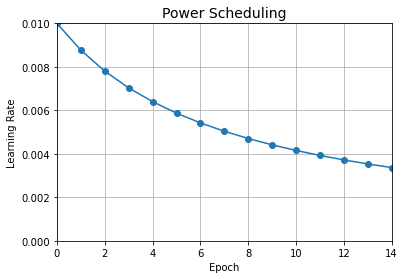

In [43]:
import math

learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = math.ceil(len(X_train) / batch_size)
epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epo
plt.plot(epochs, lrs,  "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

In [44]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)
plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 1.4])

ValueError: Data cardinality is ambiguous:
  x sizes: 50000
  y sizes: 45000
Make sure all arrays contain the same number of samples.

In [41]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.SGD(learning_rate=1e-2)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [42]:
n_epochs = 15
onecycle = OneCycleScheduler(math.ceil(len(X_train_scaled) / batch_size) * n_epochs, max_rate=0.05)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle])

NameError: name 'OneCycleScheduler' is not defined